In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Project/us-patent-phrase-to-phrase-matching'
train_path = data_dir + '/train_data.csv'
val_path = data_dir + '/val_data.csv'
test_path = data_dir + '/test_data.csv'

Mounted at /content/drive


In [4]:
class PatentDataset(Dataset):
    def process_data(self, data_df):
        score_to_class = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}
        data_df['class'] = data_df.apply(lambda x: score_to_class[x['score']], axis=1)

        y = data_df['class'].to_numpy()
        data_df = data_df.drop(columns=['score', 'class'])
        #print(list(data_df.columns))
        anchor_cols = ['anchor_' + str(i) for i in range(768)]
        target_cols = ['target_' + str(i) for i in range(768)]
        anchor_data = data_df[anchor_cols].to_numpy()
        #print('anchor_data', anchor_data)
        #print('anchor_data', anchor_data.shape)
        target_data = data_df[target_cols].to_numpy()
        #print('target_data', target_data)
        #print('target_data', target_data.shape)
        aggr_data = np.multiply(anchor_data, target_data)
        #print('aggr_data', aggr_data)
        #print('aggr_data', aggr_data.shape)
        data_df = data_df.drop(columns=anchor_cols)
        data_df = data_df.drop(columns=target_cols)
        #print('data_df', data_df.shape)
        #print('data_df', list(data_df.columns))
        context_data = data_df.to_numpy()
        #print('context_data', context_data.shape)
        X = np.concatenate((aggr_data, context_data), axis=1)
        #print(X.shape, y.shape)
        return X, y
    def __init__(self, data_path):
        super(PatentDataset, self).__init__()

        data_df = pd.read_csv(data_path)
        X, y = self.process_data(data_df)

        self.X = torch.from_numpy(X).double()
        self.y = torch.from_numpy(y).long()
        print(self.X.dtype)
        print('X.shape', self.X.shape, 'y.shape', self.y.shape)
        self.len = X.shape[0]

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.len

In [5]:
train_set = PatentDataset(train_path)
val_set = PatentDataset(val_path)
test_set = PatentDataset(test_path)

torch.float64
X.shape torch.Size([26351, 874]) y.shape torch.Size([26351])
torch.float64
X.shape torch.Size([4651, 874]) y.shape torch.Size([4651])
torch.float64
X.shape torch.Size([5471, 874]) y.shape torch.Size([5471])


In [6]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(874, 200)  # 5*5 from image dimension
        self.fc2 = nn.Linear(200, 5)
        print(self.fc2.weight.dtype, self.fc2.bias.dtype)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = Model().double().to(device)
print(sum(p.numel() for p in model.parameters()))

torch.float32 torch.float32
176005


In [9]:
def plot_loss(loss, title, xlabel, ylabel):
    epoch = list(range(len(loss)))
    plt.plot(epoch, loss)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epoch_count = 100
epoch_train_loss = []
epoch_val_loss = []
patience = np.Inf
patience_lost = 0
for epoch in range(1, epoch_count+1):
    print('Epoch', epoch)
    model.train()
    batch_train_loss = []
    for (X, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        batch_train_loss.append(loss.item())
    epoch_train_loss.append(np.mean(batch_train_loss))
    print('Train loss: %.3f' % epoch_train_loss[-1], flush=True, end='')

    batch_val_loss = []
    model.eval()
    with torch.no_grad():
        for (X, y) in tqdm(val_loader, desc='Validation epoch', leave=False):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            batch_val_loss.append(loss.item())
    epoch_val_loss.append(np.mean(batch_val_loss))
    print('Val loss: %.3f' % epoch_val_loss[-1], flush=True)
    if(epoch > 1):
        if(epoch_val_loss[-1] >= epoch_val_loss[-2]):
            patience_lost += 1
            if(patience_lost == patience):
                break
        else:
            patience_lost = 0        

Epoch 1


Training epoch 1:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.163

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.109
Epoch 2


Training epoch 2:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.043

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.075
Epoch 3


Training epoch 3:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.988

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.062
Epoch 4


Training epoch 4:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.934

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.058
Epoch 5


Training epoch 5:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.876

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.035
Epoch 6


Training epoch 6:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.816

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.043
Epoch 7


Training epoch 7:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.758

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.030
Epoch 8


Training epoch 8:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.699

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.045
Epoch 9


Training epoch 9:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.644

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.056
Epoch 10


Training epoch 10:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.591

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.064
Epoch 11


Training epoch 11:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.540

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.085
Epoch 12


Training epoch 12:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.494

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.103
Epoch 13


Training epoch 13:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.447

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.109
Epoch 14


Training epoch 14:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.407

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.141
Epoch 15


Training epoch 15:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.370

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.167
Epoch 16


Training epoch 16:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.333

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.200
Epoch 17


Training epoch 17:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.303

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.238
Epoch 18


Training epoch 18:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.271

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.259
Epoch 19


Training epoch 19:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.242

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.322
Epoch 20


Training epoch 20:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.218

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.343
Epoch 21


Training epoch 21:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.194

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.402
Epoch 22


Training epoch 22:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.174

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.439
Epoch 23


Training epoch 23:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.157

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.482
Epoch 24


Training epoch 24:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.141

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.541
Epoch 25


Training epoch 25:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.125

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.584
Epoch 26


Training epoch 26:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.113

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.621
Epoch 27


Training epoch 27:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.104

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.683
Epoch 28


Training epoch 28:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.093

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.717
Epoch 29


Training epoch 29:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.084

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.759
Epoch 30


Training epoch 30:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.077

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.839
Epoch 31


Training epoch 31:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.070

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.845
Epoch 32


Training epoch 32:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.066

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.919
Epoch 33


Training epoch 33:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.062

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.952
Epoch 34


Training epoch 34:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.055

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.000
Epoch 35


Training epoch 35:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.053

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.013
Epoch 36


Training epoch 36:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.049

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.065
Epoch 37


Training epoch 37:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.048

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.089
Epoch 38


Training epoch 38:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.044

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.169
Epoch 39


Training epoch 39:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.044

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.198
Epoch 40


Training epoch 40:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.041

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.203
Epoch 41


Training epoch 41:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.036

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.286
Epoch 42


Training epoch 42:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.038

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.279
Epoch 43


Training epoch 43:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.033

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.289
Epoch 44


Training epoch 44:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.032

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.323
Epoch 45


Training epoch 45:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.030

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.376
Epoch 46


Training epoch 46:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.034

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.425
Epoch 47


Training epoch 47:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.030

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.373
Epoch 48


Training epoch 48:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.028

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.476
Epoch 49


Training epoch 49:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.029

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.485
Epoch 50


Training epoch 50:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.026

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.477
Epoch 51


Training epoch 51:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.026

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.492
Epoch 52


Training epoch 52:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.023

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.565
Epoch 53


Training epoch 53:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.023

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.591
Epoch 54


Training epoch 54:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.025

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.608
Epoch 55


Training epoch 55:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.020

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.686
Epoch 56


Training epoch 56:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.021

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.695
Epoch 57


Training epoch 57:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.024

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.710
Epoch 58


Training epoch 58:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.023

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.805
Epoch 59


Training epoch 59:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.022

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.730
Epoch 60


Training epoch 60:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.786
Epoch 61


Training epoch 61:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.016

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.849
Epoch 62


Training epoch 62:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.020

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.798
Epoch 63


Training epoch 63:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.022

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.862
Epoch 64


Training epoch 64:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.797
Epoch 65


Training epoch 65:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.017

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.928
Epoch 66


Training epoch 66:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.917
Epoch 67


Training epoch 67:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.015

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.962
Epoch 68


Training epoch 68:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.002
Epoch 69


Training epoch 69:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.940
Epoch 70


Training epoch 70:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.017

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.990
Epoch 71


Training epoch 71:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.014

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.983
Epoch 72


Training epoch 72:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.016

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.119
Epoch 73


Training epoch 73:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.047
Epoch 74


Training epoch 74:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.016

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.026
Epoch 75


Training epoch 75:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.014

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.092
Epoch 76


Training epoch 76:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.015

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.103
Epoch 77


Training epoch 77:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.016

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.157
Epoch 78


Training epoch 78:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.011

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.150
Epoch 79


Training epoch 79:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.018

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.159
Epoch 80


Training epoch 80:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.017

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.185
Epoch 81


Training epoch 81:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.011

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.159
Epoch 82


Training epoch 82:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.013

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.198
Epoch 83


Training epoch 83:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.016

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.215
Epoch 84


Training epoch 84:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.014

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.253
Epoch 85


Training epoch 85:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.013

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.426
Epoch 86


Training epoch 86:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.014

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.261
Epoch 87


Training epoch 87:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.010

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.234
Epoch 88


Training epoch 88:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.017

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.273
Epoch 89


Training epoch 89:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.012

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.265
Epoch 90


Training epoch 90:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.011

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.310
Epoch 91


Training epoch 91:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.010

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.360
Epoch 92


Training epoch 92:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.012

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.341
Epoch 93


Training epoch 93:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.015

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.373
Epoch 94


Training epoch 94:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.013

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.433
Epoch 95


Training epoch 95:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.011

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.390
Epoch 96


Training epoch 96:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.017

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.409
Epoch 97


Training epoch 97:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.012

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.445
Epoch 98


Training epoch 98:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.009

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.429
Epoch 99


Training epoch 99:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.010

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.556
Epoch 100


Training epoch 100:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.010

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.472


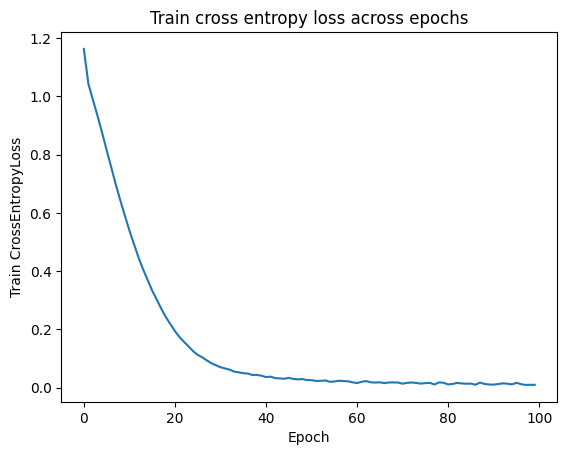

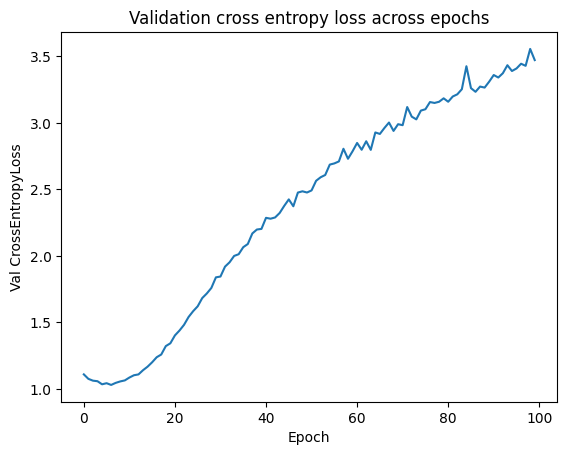

In [12]:
plot_loss(epoch_train_loss, 'Train cross entropy loss across epochs', 'Epoch', 'Train CrossEntropyLoss')
plot_loss(epoch_val_loss, 'Validation cross entropy loss across epochs', 'Epoch', 'Val CrossEntropyLoss')

In [13]:
from scipy.special import softmax
from sklearn.metrics import classification_report

def calc_metrics(dataset, model):
    y_true = None
    y_pred = None
    with torch.no_grad():
        X, y = dataset.X.to(device), dataset.y.to(device)
        pred = model(X)
        y_true = y.cpu().detach().numpy()
        y_pred = pred.cpu().detach().numpy()
    y_pred = softmax(y_pred, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    report = classification_report(y_true, y_pred)
    print(report)

In [14]:
print('Train evaluation')
calc_metrics(train_set, model)
print('Validation evaluation')
calc_metrics(val_set, model)
print('Test evaluation')
calc_metrics(test_set, model)

Train evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5342
           1       1.00      1.00      1.00      8324
           2       1.00      1.00      1.00      8912
           3       1.00      1.00      1.00      2912
           4       1.00      0.99      1.00       861

    accuracy                           1.00     26351
   macro avg       1.00      1.00      1.00     26351
weighted avg       1.00      1.00      1.00     26351

Validation evaluation
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      1005
           1       0.65      0.61      0.63      1453
           2       0.59      0.65      0.62      1559
           3       0.48      0.41      0.44       498
           4       0.59      0.42      0.49       136

    accuracy                           0.59      4651
   macro avg       0.57      0.53      0.55      4651
weighted avg       0.59      0.59     